In [1]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import pandas as pd
import numpy as np
import re
import string
import contractions
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [2]:
# Load in the pre-appointment-data.csv
df = pd.read_csv('data/pre-appointment-data.csv')

# Mix the order of the data
# df = df.sample(frac=1).reset_index(drop=True)

# Drop the columns that we don't need (duration, symptom_severity, symptom_cause, additional_symptoms, medical_history, appointment_expectations, health_concerns, health_experiences)
df = df.drop(['duration', 'symptom_severity', 'symptom_cause', 'additional_symptoms', 'medical_history', 'appointment_expectations', 'health_concerns', 'health_experiences'], axis=1)

# show the first 5 rows of the data
df.head()

,reason_for_visit,symptoms,symptom_type
0,Exposure to mold,"Cough, sneezing, watery eyes",Respiratory
1,Respiratory infection symptoms,"Can't get my breath, chest feels tight, coughi...",Respiratory
2,Sinus infection,"Cough, congestion, sinus pressure",Respiratory
3,Difficulty breathing and wheezing,"Difficulty breathing, wheezing, coughing",Respiratory
4,Bronchitis symptoms,"Cough, phlegm production, chest pain",Respiratory


In [3]:
# make a new dataframe with only symptom_type
symptom_type_df = df['symptom_type']

In [4]:
# make a new dataframe with only reason_for_visit
df_reason_for_visit = df[['reason_for_visit']]

# lower casing
df_reason_for_visit = df_reason_for_visit.copy()
df_reason_for_visit['reason_for_visit'] = df_reason_for_visit['reason_for_visit'].str.lower()

# expand contractions
df_reason_for_visit = df_reason_for_visit['reason_for_visit'].str.split()
df_reason_for_visit = df_reason_for_visit.apply(
    lambda x: " ".join([contractions.fix(expanded_word) for expanded_word in x])
)

# create new dataframe with expanded contractions
df_reason_for_visit = pd.DataFrame(df_reason_for_visit)

# remove punctuations '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'
df_reason_for_visit = df_reason_for_visit['reason_for_visit'].apply(
    lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

# get rid of double spaces
df_reason_for_visit = df_reason_for_visit.apply(lambda x: re.sub(' +', ' ', x))

lemmatizer = WordNetLemmatizer()
df_reason_for_visit = df_reason_for_visit.apply(lambda x: lemmatizer.lemmatize(x))

# create a new dataframe from the lemmatized data
df_reason_for_visit = pd.DataFrame(df_reason_for_visit)
df_reason_for_visit.head()

,reason_for_visit
0,exposure to mold
1,respiratory infection symptoms
2,sinus infection
3,difficulty breathing and wheezing
4,bronchitis symptoms


In [5]:
# make a new dataframe with only symptoms
df_symptoms = df[['symptoms']]

# lower casing
df_symptoms = df_symptoms.copy()
df_symptoms['symptoms'] = df_symptoms['symptoms'].str.lower()

# expand contractions
df_symptoms = df_symptoms['symptoms'].str.split()
df_symptoms = df_symptoms.apply(
    lambda x: " ".join([contractions.fix(expanded_word) for expanded_word in x])
)

# create new dataframe with expanded contractions
df_symptoms = pd.DataFrame(df_symptoms)

# remove punctuations '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'
df_symptoms = df_symptoms['symptoms'].apply(
    lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

# get rid of double spaces
df_symptoms = df_symptoms.apply(lambda x: re.sub(' +', ' ', x))

lemmatizer = WordNetLemmatizer()
df_symptoms = df_symptoms.apply(lambda x: lemmatizer.lemmatize(x))

# create a new dataframe from the lemmatized data
df_symptoms = pd.DataFrame(df_symptoms)
df_symptoms.head()

,symptoms
0,cough sneezing watery eyes
1,cannot get my breath chest feels tight coughin...
2,cough congestion sinus pressure
3,difficulty breathing wheezing coughing
4,cough phlegm production chest pain


In [6]:
# combine df_reason_for_visit, df_symptoms, and symptom_type_df
df = pd.concat([df_reason_for_visit, df_symptoms, symptom_type_df], axis=1)
df.head()

# export df to csv
df.to_csv('data/text-pre-processing.csv', index=False)

In [7]:
# Load in the pre-appointment-data
df = pd.read_csv('data/text-pre-processing.csv')

# Encode the non-numeric columns
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(df[col])

# Drop the label to create the X data
X = df.drop('symptom_type', axis=1)

# df symptom_type column
# Encode the labels
y = LabelEncoder().fit_transform(df['symptom_type'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# classifier from scikit-learn

# Split the data into training and test sets
X = df.drop('symptom_type', axis=1)
y = df['symptom_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing and scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a machine learning model | classifier from scikit-learn
model = LogisticRegression(solver='lbfgs', multi_class='auto')
model.fit(X_train, y_train)

# Evaluate the model
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

Train accuracy: 0.53
Test accuracy: 0.42


In [9]:
# support vector machine (SVM)

# Split the data into training and test sets
X = df.drop('symptom_type', axis=1)
y = df['symptom_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing and scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a machine learning model | support vector machine (SVM)
model = SVC(kernel='rbf', gamma='auto')
model.fit(X_train, y_train)

# Evaluate the model
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

Train accuracy: 0.78
Test accuracy: 0.82


## random forest classifier (The Winner)

In [10]:
# random forest classifier

# Split the data into training and test sets
X = df.drop('symptom_type', axis=1)
y = df['symptom_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing and scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a machine learning model | support vector machine (SVM)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

Train accuracy: 1.00
Test accuracy: 0.91


In [15]:
# create classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training data
classifier.fit(X_train, y_train)

# make predictions on the test data
predictions = classifier.predict(X_test)

# Print the first 10 actual and predicted values
print(f'Actual:\t\t{list(y_test[:10])}')
print(f'Predicted:\t{list(predictions[:10])}')

Actual:		[0, 0, 0, 1, 2, 0, 1, 1, 0, 0]
Predicted:	[0, 0, 0, 0, 2, 0, 1, 1, 0, 0]


/var/folders/_r/33n0_r6j30zdld79w7tl1h6c0000gn/T/ipykernel_17064/1633690795.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(f'Actual:\t\t{list(y_test[:10])}')


In [12]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Extract the number of true negatives, false positives, false negatives, and true positives
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

# Calculate the accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate the precision
precision = tp / (tp + fp)

# Calculate the recall
recall = tp / (tp + fn)

# Calculate the f1 score
f1 = 2 * (precision * recall) / (precision + recall)

# Print the accuracy, precision, recall, and f1 score
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")


Accuracy: 0.94
Precision: 0.92
Recall: 0.92
F1: 0.92


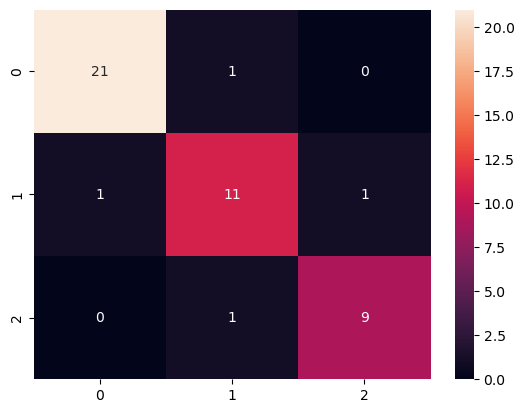

In [13]:
# Plot the confusion matrix using a heatmap
sns.heatmap(cm, annot=True)
plt.show()

In [14]:
# Save the model to a file
with open('RandomForestClassifier.pkl', 'wb') as file:
    pickle.dump(model, file)